#  An Exploratory Analysis of the USA Border Crossing Data

## Introduction

In the initial section here, the relevant packages and the dataset shall be imported. Given we want to use descriptive statistics and respective plots, the plotly packages will be handy in order to understand regressively. Note, every time you attempt this, you need to remember to 'Shift'+'Enter' from the **first line**, because 'Date' is removed after a point, and Jupyter will get confused if you go from the middle.

In [3]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.gridspec as mgrid
from IPython.display import Image

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
# Reading the dataset
border_data = pd.read_csv('Border_Crossing_Entry_Data.csv')

In [5]:
# Reading the Border Entry details
border_data['Border'].value_counts()

US-Canada Border    266187
US-Mexico Border     80546
Name: Border, dtype: int64

In [6]:
# Reading the mode of commute
border_data['Measure'].value_counts()

Personal Vehicles              30219
Personal Vehicle Passengers    30196
Trucks                         29856
Truck Containers Empty         29757
Truck Containers Full          29694
Buses                          28822
Bus Passengers                 28820
Pedestrians                    28697
Trains                         27708
Rail Containers Empty          27684
Rail Containers Full           27657
Train Passengers               27623
Name: Measure, dtype: int64

In [7]:
# Reading of the most popular state(s) to commute to the borders from
# Note that in subsequent analyses we can determine which borders are more active. 
border_data['State'].value_counts()

North Dakota    57071
Washington      44677
Montana         38154
Maine           38136
Texas           35754
Minnesota       23135
New York        20697
Arizona         19252
California      19102
Vermont         16247
Alaska          11529
Michigan         9985
Idaho            6551
New Mexico       6438
Ohio                5
Name: State, dtype: int64

Our goal here is to convert the Date column into separate columns of Years and Months of the relevant port crossings. This breakdown will be helpful in understanding which ports have been popular entry ports and modes of commute in certain times of the year. 

In [8]:
border_data['Date'] = pd.to_datetime(border_data['Date'])

In [9]:
# Here, w
border_data['Year'] = border_data['Date'].apply(lambda x : x.year)

In [10]:
border_data['Month'] = border_data['Date'].apply(lambda x : x.month)
month_numerals = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
border_data['Month'] = border_data['Month'].apply(lambda x: month_numerals[x])

The Date column will be removed, as we ideally want the Year and Month columns to help us break down the border crossing methods and techniques. 

In [11]:
# Date column has been dropped, for the sake of ease
border_data.drop(columns = 'Date', inplace = True)

In [12]:
# Can see that Date column was removed, and instead Year and Month are included
border_data.head()

Port Name       State  Port Code            Border  \
0  Calexico East  California       2507  US-Mexico Border   
1      Van Buren       Maine        108  US-Canada Border   
2      Otay Mesa  California       2506  US-Mexico Border   
3        Nogales     Arizona       2604  US-Mexico Border   
4    Trout River    New York        715  US-Canada Border   

                       Measure  Value                               Location  \
0                       Trucks  34447   POINT (-115.48433000000001 32.67524)   
1         Rail Containers Full    428             POINT (-67.94271 47.16207)   
2                       Trucks  81217            POINT (-117.05333 32.57333)   
3                       Trains     62  POINT (-110.93361 31.340279999999996)   
4  Personal Vehicle Passengers  16377   POINT (-73.44253 44.990010000000005)   

   Year Month  
0  2019   Mar  
1  2019   Mar  
2  2019   Mar  
3  2019   Mar  
4  2019   Mar

The next step will help us understand and determine how many values were used in each year. We should hopefully get that every year has 12 days being assessed (as it is the first day of each month that was assessed), except for 2019 that has 3 days. This is because the compilers of the data recorded from January 1996 to March 2019.

In [13]:
border_data.groupby(['Year', 'Month'])['Port Code'].count().reset_index().groupby(['Year'])['Month'].count()

Year
1996    12
1997    12
1998    12
1999    12
2000    12
2001    12
2002    12
2003    12
2004    12
2005    12
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019     3
Name: Month, dtype: int64

Next, we want to drop any duplicates, as well as spot of any Port Names and/or Codes overlap. This will an important piece of information to check!

In [14]:
border_duplicates = border_data[['Port Name','Port Code']].drop_duplicates()
border_duplicates[border_duplicates['Port Name'].duplicated(keep = False)]

Port Name  Port Code
29   Eastport       3302
217  Eastport        103

Right - The port Eastport has two port codes (I don't know why do they do this to us), which are 3302 and 103. We now want to find where exactly they are located. Let's find out! 

In [15]:
border_data.loc[border_data['Port Name'] == 'Eastport',].groupby(['State', 'Port Name', 'Port Code'])['State'].count()

State  Port Name  Port Code
Idaho  Eastport   3302         3345
Maine  Eastport   103          2196
Name: State, dtype: int64

Aha, so there's Eastport in Idaho (with Port Code 3302) and an Eastport in Maine (with Port Code 103). We want to make sure that in our subsequent analyses, we do not get confused with these two ports, particularly when we determine which ports are popular entry points. 

## 1. Border Crossing

In this section, we now want to determine which border crossing country is more popular, the breakdown of the mode of entry and the months of the year that are popular. Based on this we can make conclusions regarding what modes of entry are suited to certain crossing routes. 

In [16]:
# The border crossings being addressed (as well the only countries the USA borders)
print(border_data['Border'].unique())

['US-Mexico Border' 'US-Canada Border']


In [17]:
# The modes of commute used by individuals when making entry into the USA - we somewhat found this earlier.
print(border_data['Measure'].unique())

['Trucks' 'Rail Containers Full' 'Trains' 'Personal Vehicle Passengers'
 'Bus Passengers' 'Truck Containers Empty' 'Rail Containers Empty'
 'Personal Vehicles' 'Buses' 'Truck Containers Full' 'Pedestrians'
 'Train Passengers']


In [18]:
total_people = border_data[border_data['Measure'].isin(['Personal Vehicle Passengers','Bus Passengers','Pedestrians','Train Passengers'])]
total_vehicles = border_data[border_data['Measure'].isin(['Trucks','Rail Containers Full','Trains','Truck Containers Empty','Rail Containers Empty','Personal Vehicles','Buses','Truck Containers Full'])]

In [19]:
# The total number of people entering into the United States
total_people[['Border','Value']].groupby(['Border']).sum()

Value
Border                      
US-Canada Border  1631864476
US-Mexico Border  5018273234

The above information tells us that over this time frame, the US-Mexico Border has had the greatest popularity, with over 5 billion people crossings happening in US-Mexico Borders alone. The next goal is to find a breakdown of the vehicles crossing, as well as the months of the year where this is occurring. It shall be broken down based on the border crossing country.

In [20]:
# The total number of vehicles entering into the United States
total_vehicles[['Border','Value']].groupby(['Border']).sum()

Value
Border                      
US-Canada Border  1056098318
US-Mexico Border  2067358814

Once again the US-Mexico border is the most popular of the two borders for vehicle crossings entering the United States. Graphically it is represented below.

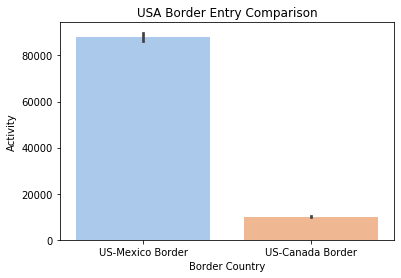

In [21]:
sns.barplot(x=border_data['Border'], y=border_data['Value'], palette = 'pastel')
plt.xlabel('Border Country')
plt.ylabel('Activity')
plt.title('USA Border Entry Comparison')
plt.show()

Above shows that the US-Mexico border clearly the more active border crossing for the USA, as against the US-Canada border. Now we want to see what commuting method is the most popular. The commuting methods shall be broken down into two graphs - the first being a cumulative graph, combining methods from US-Canada and US-Mexico, and the second graph is broken down based on the bordering country.

In [22]:
entry_data = pd.DataFrame(border_data.groupby(by='Measure')['Value'].sum().sort_values(ascending=False)).reset_index()
entry_population = px.bar(entry_data, 
                          x='Measure', 
                          y='Value', 
                          height = 500, 
                          color_discrete_sequence = ['#ff0000'])
entry_population.show()

In [23]:
entry_data = border_data.groupby(by=['Border','Measure'])['Value'].sum().reset_index()
entry_data.fillna(0, inplace = True)
entry_data.sort_values(by='Value', inplace=True)
entry_population = px.bar(entry_data, x='Measure', y='Value', color='Border', barmode='group', height=500)
entry_population.show()
del entry_data

The above graphs show us that both northern and southern border crossings prefer the usage of personal vehicles. It can be noted though that unlike in the US-Canada Border, the southern border has a high inflow of pedestrians into the United States. 

Now we want to compare the border crossing activity across all the years studied (1996 to 2019). This comparison will give us a breakdown of the popularity of the border crossing country, which in turn will help deduce the popular ports that make up the border crossing.

In [24]:
entry_data = border_data.groupby(['Border','Year'])['Value'].sum().reset_index()
year_frequency = px.line(x='Year', y='Value', data_frame=entry_data, color='Border',
                        labels={'Border':'Border', 'Value':'Number of Border Entries', 'Year':'Year'},
                        width=1000,
                        height=500,
                        title = 'US-Mexico and US-Canada Border Crossing (from 1996-2019)')
year_frequency.update_traces(mode='markers+lines')
year_frequency

As determined from the previous descriptives, the US-Mexico border clearly had the greater popularity over the years, but we can see that while US-Canada has been more-or-less steady in its growth, US-Mexico border crossing rates have been following a declining trend, particularly since the eve of the 21st century. The border entry gap was the widest during 2000 and narrowed around 2011, but since then, US-Mexico has seemed to follow an increasing trend yet again. 

The next aspect we intend to deduce is regarding which months of the year have appeared popular for the border crossings.

In [25]:
entry_data = border_data.groupby(['Border', 'Year', 'Month'])['Value'].sum().reset_index()

# Maximum and Minimum Values for the Border Crossing Months
maximum = entry_data.groupby(['Border','Year'])['Value'].idxmax().values
minimum = entry_data.groupby(['Border','Year'])['Value'].idxmin().values

# This establishes which value is the Maximum and Minimum
entry_data.loc[maximum, 'Value Type'] = 'Max'
entry_data.loc[minimum, 'Value Type'] = 'Min'

entry_data.dropna(subset = ['Value Type'], inplace = True)

In [26]:
entry_data = entry_data.merge(entry_data.groupby(['Border','Year'])['Value'].sum().reset_index().rename(
    columns = {'Value':'Total Value'}), on=['Border','Year'])

In [27]:
entry_data['Prop'] = round(entry_data['Value']*100 / entry_data['Total Value'], 2).astype('str') + '%'

In [28]:
min_max_canada = px.bar(x='Year', 
                y='Value', 
                data_frame = entry_data.loc[entry_data['Border'] == 'US-Canada Border'],
                color = 'Month', 
                labels = {'Month':'Month', 'Value':'Number of Border Entries', 'Year':'Year Month', 'Prop':'Proportion'},
                title = 'The Min-Max of Border Crossings between US-Canada',
                hover_data = ['Prop'],
                text = 'Month')
min_max_canada.show()

The graph above shows that for the bulk of those years (excluding 2019), **July** and **August (majority of the years)** were particularly popular months for entrants to the USA from Canada. This could be attributed to the warmer weathers of the summer months and so, making the commute easier. Moreover, given the majority of commuters chose personal vehicles on this crossing, travelling in the warmer climates are arguably less arduous. This is why the bars in the bar graph above shows a majority for these months. 

On the contrary, **December (minority of the years)** **January** and **February (majority of the years)** were the least popular months to travel, understandably the winter months. 

In [29]:
min_max_mexico = px.bar(x='Year', 
                y='Value', 
                data_frame = entry_data.loc[entry_data['Border'] == 'US-Mexico Border'],
                color = 'Month', 
                labels = {'Month':'Month', 'Value':'Number of Border Entries', 'Year':'Year Month', 'Prop':'Proportion'},
                title = 'The Min-Max of Border Crossings between US-Mexico',
                hover_data = ['Prop'],
                text = 'Month')
min_max_mexico.show()

In the US-Mexico border crossing, **December** was the most popular month for entering the United States, and **March** being the second most popular. The least popular month for entering the United States through this border is **February**.

## 2. Ports

In this section we intend to understand the most popular entry points, in terms of the port names itself. 

In [30]:
entry_data = border_data.groupby(['Border', 'Port Name'])['Value'].sum().reset_index()
entry_data['Rank'] = entry_data.groupby(['Border'])['Value'].rank(ascending = False)
entry_data = entry_data.loc[entry_data['Rank'] <=200]

In [31]:
from_port = (entry_data['Border'] == 'US-Canada Border')
port_1 = entry_data.loc[from_port, ].sort_values(by='Value', ascending = False)['Port Name'].tolist()

plot_1 = px.bar(x = 'Port Name',
                         y = 'Value',
                         data_frame = entry_data.loc[from_port],
                         labels = {'Port Name':'Port Name', 'Value':'Number of Border Entries'},
                         title = 'Border Entry Ports in the US-Canada Border',
                         category_orders = {'Port Name':port_1},
                         color_discrete_sequence = ['#ff0000'])
plot_1.show()

The above graph shows the top 5 border crossings, in order, are **Buffalo-Niagara Falls (1st), Detroit (2nd), Blaine (3rd), Port Huron (4th) and Champlain-Rouses Point (5th)**. We want to see how the US-Mexico border entry ports fared, particularly since in the earlier plots in this exploratory analysis revealed a far greater activity on the southern border than the northern border. 

In [32]:
from_port = (entry_data['Border'] == 'US-Mexico Border')
port_1 = entry_data.loc[from_port, ].sort_values(by = 'Value', ascending = False)['Port Name'].tolist()
plot_1 = px.bar(x = 'Port Name',
                y = 'Value',
                data_frame = entry_data.loc[from_port],
                labels = {'Port Name':'Port Name', 'Value':'Number of Border Entries'},
                title = 'Border Entry Ports in the US-Mexico Border',
                category_orders = {'Port_Name':port_1},
                color_discrete_sequence = ['#ff0000'])
plot_1.show()

The above information reveals that the 5 most popular border crossing ports are **El Paso (1st), San Ysidro (2nd), Laredo (3rd), Hidalgo (4th) and Calexico (5th)**. In fact, a statistical fact we can note is that 4 out of these top 5 border crossing ports in the US-Mexico Border *exceed* the most popular crossing port in the US-Canada Border (the Buffalo-Niagara Falls port). 

In [33]:
mover_of_traffic = {'Personal Vehicle Passengers':'Small',
              'Personal Vehicles':'Small',
              'Pedestrians':'Small',
              'Bus Passengers':'Small',
              'Train Passengers':'Small',
              'Trucks':'Medium',
              'Truck Containers Full':'Medium',
              'Truck Containers Empty':'Medium',
              'Rail Containers Empty':'Medium',
              'Rail Containers Full':'Medium',
              'Buses':'Large',
              'Trains':'Large'}
border_data['Movement'] = border_data['Measure'].map(mover_of_traffic)

<Figure size 720x360 with 0 Axes>

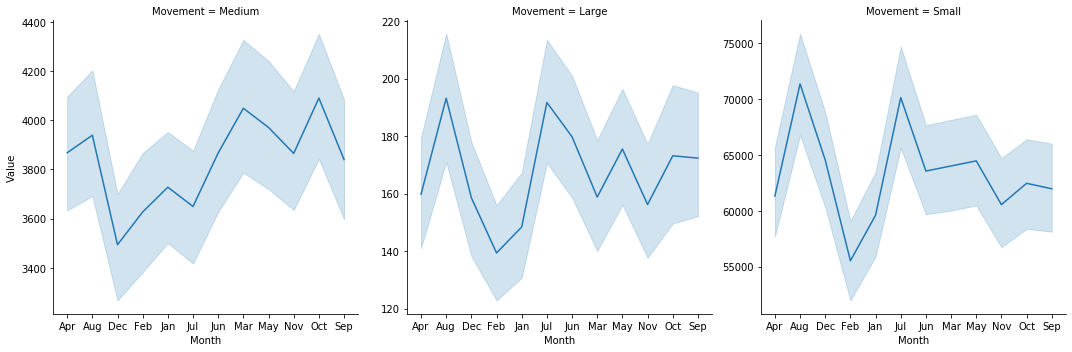

In [34]:
plt.figure(figsize=(10,5))
seasonal_plot = sns.FacetGrid(data = border_data, col='Movement', sharey=False, height=5, aspect=1)
seasonal_plot.map(sns.lineplot, 'Month', 'Value')

The above analysis involved concising some of the data - given the constraints of project time, as well as ease of reading (otherwise to reproduce a chart for all modes is possible, yet time consuming), I split the commuting modes into Small, Medium and Large movers of traffic. Typical **small** movers of traffic were commutes that involved pedestrians, personal vehicles, as well as the passengers of the main modes, train and bus. 

The **medium** movers of traffic are the trucks and rail cargos. Given these involve taking goods and services, more than people, this segregation could allow us to see the frequency of trucks and cargo railways entering the United States from the borders. 

The **large** movers of traffic were typically the ones carrying the most passengers, such as the buses/coaches and trains.

Based on the graphs above, there was a seasonal trend among all three cases, particularly during the winter months (December, January and February). There was a very minimal inflow of the above, and can be attributed to  the weather. The summer months all had a massive inflow, particularly the **small** movers, which had an activity of around 70M during the summer months. This exemplifies that the ideal time to travel across borders would be the summer months.

Text(0.5, 1.0, 'Popularity of Commute Method based on Months')

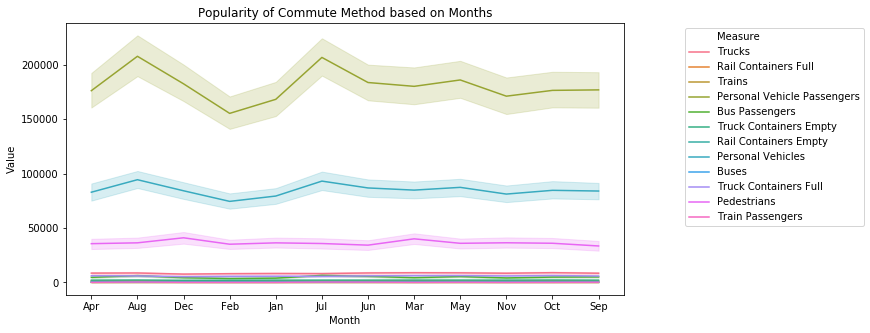

In [35]:
plt.figure(figsize=(10,5))
sns.lineplot(data = border_data, x='Month', y='Value', legend = 'full', hue = 'Measure')
plt.legend(bbox_to_anchor = (1.1, 1),loc = 'upper left')
plt.title('Popularity of Commute Method based on Months')

During all times of the year, personal vehicles and its passengers represent the most popular method of entry into the United States, when border crossing. We can see that while being a pedestrian represents the third most popular commute method, all other methods are clearly overshadowed, which can be attributed to its lesser abundance and use of those methods, as well as conveninence. 

In [36]:
entry_data = border_data.groupby(by=['Movement','State', 'Border'])['Value'].sum()
entry_data.fillna(0, inplace = True)
entry_data = entry_data.reset_index()
px.bar(entry_data, x='State', y='Value', facet_col = 'Movement')

To show the *Port Name* was tricky in this instance, because it did not display all the port names. 

The movement patterns displayed some interesting results for *small movers*, in that the most popular border crossing states were **Texas** and **California** - both of which are US-Mexico bordering states. While **Arizona** was third, the first US-Canada bordering states that appeared was **New York (4th)**, and closely followed by **Michigan (5th)**. 

It must be noted that for *medium movers*, these four states were dominant once again, except California and Arizona taking a clear back-seat, and instead **Michigan** and **New York** moving up to 2nd and 3rd place respectively. **Texas** still remained in 1st place.

In [37]:
entry_data = border_data.groupby(by=['Movement','Border'])['Value'].sum()
entry_data.fillna(0, inplace = True)
entry_data = entry_data.reset_index()
px.bar(entry_data, x='Border', y='Value', facet_col = 'Movement')

This shows how US-Mexico Border entrants was clearly favoured for *small* movers of traffic, on a convincing scale. The *medium* movements were favoured in the US-Canada border, but it is not by a substantial margin. Nevertheless, it can be inferred that for border crossing into the United States, *small* movers of traffic are preferred. 

#### Popular months for port activity - US-Canada Border

In [38]:
uscan_top5 = pd.read_csv('Border_US_Can_Top5.csv')

In [39]:
uscan_top5['Date'] = pd.to_datetime(uscan_top5['Date'])

In [40]:
uscan_top5['Year'] = uscan_top5['Date'].apply(lambda x : x.year)

In [41]:
uscan_top5['Month'] = uscan_top5['Date'].apply(lambda x : x.month)
month_numerals = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
uscan_top5['Month'] = uscan_top5['Month'].apply(lambda x: month_numerals[x])

In [42]:
uscan_top5.drop(columns = 'Date', inplace = True)

In [43]:
uscan_top5.groupby(['Year', 'Month'])['Port Code'].count().reset_index().groupby(['Year'])['Month'].count()

Year
1996    12
1997    12
1998    12
1999    12
2000    12
2001    12
2002    12
2003    12
2004    12
2005    12
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019     3
Name: Month, dtype: int64

In [44]:
uscan_duplicates = uscan_top5[['Port Name','Port Code']].drop_duplicates()
uscan_duplicates[uscan_duplicates['Port Name'].duplicated(keep = False)]

Empty DataFrame
Columns: [Port Name, Port Code]
Index: []

In [45]:
uscan_top5.head()

Port Name       State  Port Code            Border  \
0  Champlain-Rouses Point    New York        712  US-Canada Border   
1                  Blaine  Washington       3004  US-Canada Border   
2              Port Huron    Michigan       3802  US-Canada Border   
3  Champlain-Rouses Point    New York        712  US-Canada Border   
4  Champlain-Rouses Point    New York        712  US-Canada Border   

                 Measure  Value                     Location  Year Month  
0                 Trucks  24759   POINT (-73.44694 44.98639)  2019   Mar  
1                 Trucks  31601  POINT (-122.74583 48.99389)  2019   Mar  
2   Rail Containers Full  22879   POINT (-82.47889 42.97583)  2019   Mar  
3  Truck Containers Full  22955   POINT (-73.44694 44.98639)  2019   Mar  
4      Personal Vehicles  65555   POINT (-73.44694 44.98639)  2019   Mar

In [46]:
uscan_traffic = {'Buffalo-Niagara Falls':'Buffalo-Niagara Falls',
              'Detroit':'Detroit',
              'Blaine':'Blaine',
              'Port Huron':'Port Huron',
              'Champlain-Rouses Point':'Champlain-Rouses Point'}
uscan_top5['Movement'] = uscan_top5['Port Name'].map(uscan_traffic)

<Figure size 360x216 with 0 Axes>

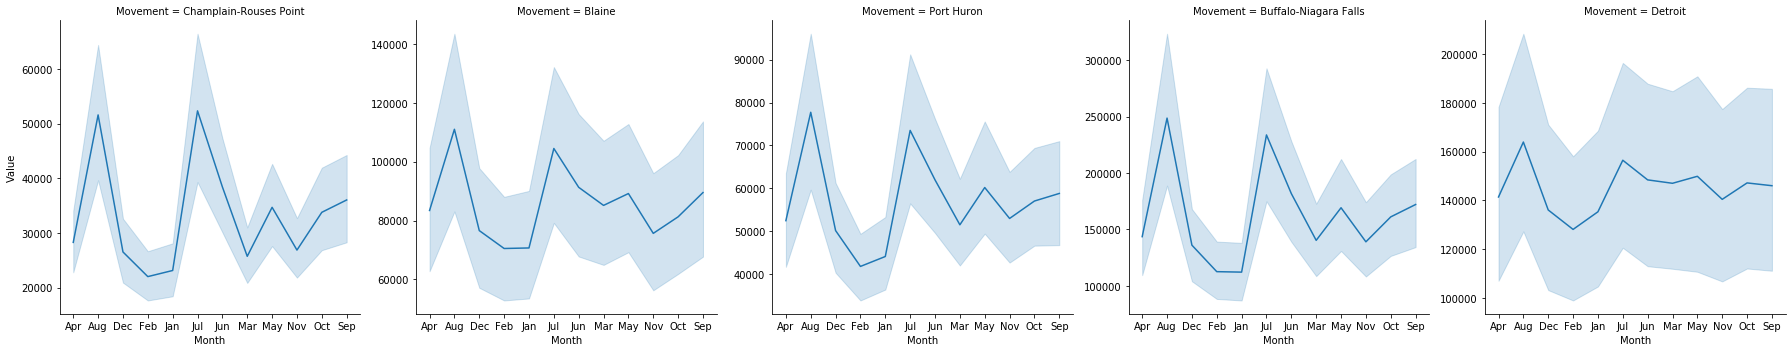

In [47]:
plt.figure(figsize=(5,3))
seasonal_plot = sns.FacetGrid(data = uscan_top5, col='Movement', sharey=False, height=5, aspect=1)
seasonal_plot.map(sns.lineplot, 'Month', 'Value')

**Summary:**
In this leg of the task, I decided to analyse the five most popular ports in the US-Canada border, and note the trends regarding which months were popular. The summer months were undoubtedly the months when peaks of inflows happened - between June to August. The winter months (December to February) had a great decline, which once again could be attributed to trickier travelling conditions, and the only incentive being that it is the festive season.  

#### Popular months for ports - US-Mexico Border

In [48]:
usmex_top5 = pd.read_csv('Border_US_Mex_Top5.csv')

In [49]:
usmex_top5['Date'] = pd.to_datetime(usmex_top5['Date'])

In [50]:
usmex_top5['Year'] = usmex_top5['Date'].apply(lambda x : x.year)

In [51]:
usmex_top5['Month'] = usmex_top5['Date'].apply(lambda x : x.month)
month_numerals = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
usmex_top5['Month'] = usmex_top5['Month'].apply(lambda x: month_numerals[x])

In [52]:
usmex_top5.drop(columns = 'Date', inplace = True)

In [53]:
usmex_top5.groupby(['Year', 'Month'])['Port Code'].count().reset_index().groupby(['Year'])['Month'].count()

Year
1996    12
1997    12
1998    12
1999    12
2000    12
2001    12
2002    12
2003    12
2004    12
2005    12
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019     3
Name: Month, dtype: int64

In [54]:
usmex_duplicates = usmex_top5[['Port Name','Port Code']].drop_duplicates()
usmex_duplicates[usmex_duplicates['Port Name'].duplicated(keep = False)]

Empty DataFrame
Columns: [Port Name, Port Code]
Index: []

In [55]:
usmex_top5.head()

Port Name       State  Port Code            Border  \
0  San Ysidro  California       2504  US-Mexico Border   
1  San Ysidro  California       2504  US-Mexico Border   
2    Calexico  California       2503  US-Mexico Border   
3     El Paso       Texas       2402  US-Mexico Border   
4     Hidalgo       Texas       2305  US-Mexico Border   

                       Measure   Value                               Location  \
0               Bus Passengers    7779   POINT (-117.02666999999998 32.54306)   
1                        Buses    3329   POINT (-117.02666999999998 32.54306)   
2                  Pedestrians  346158   POINT (-115.49806000000001 32.67889)   
3         Rail Containers Full    3162  POINT (-106.48639 31.758610000000004)   
4  Personal Vehicle Passengers  789452                 POINT (-98.26278 26.1)   

   Year Month  
0  2019   Mar  
1  2019   Mar  
2  2019   Mar  
3  2019   Mar  
4  2019   Mar

In [56]:
usmex_traffic = {'El Paso':'El Paso',
              'San Ysidro':'San Ysidro',
              'Laredo':'Laredo',
              'Hidalgo':'Hidalgo',
              'Calexico':'Calexico'}
usmex_top5['Movement'] = usmex_top5['Port Name'].map(usmex_traffic)

<Figure size 360x216 with 0 Axes>

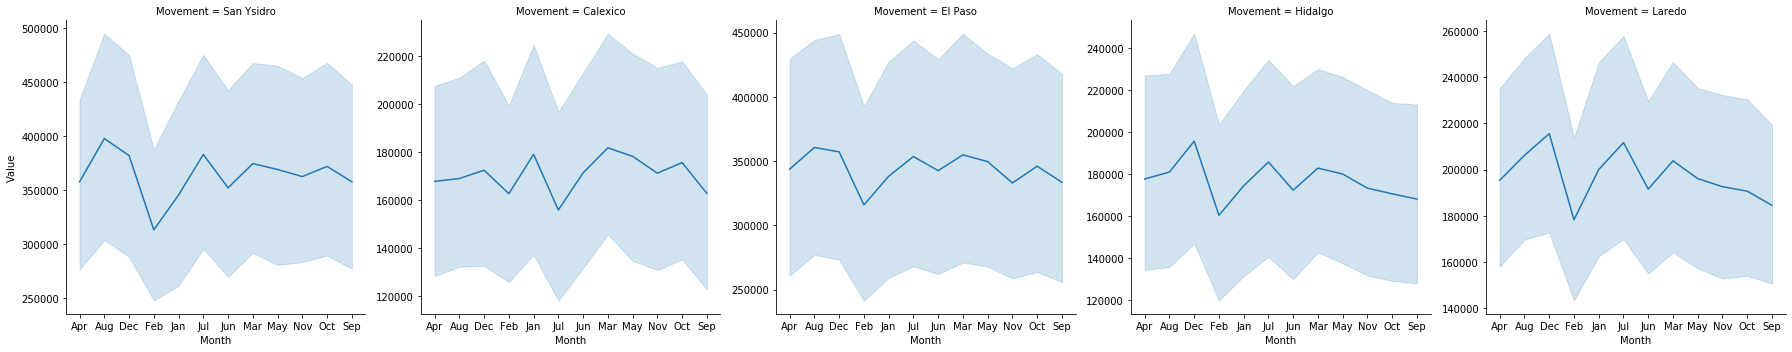

In [57]:
plt.figure(figsize=(5,3))
seasonal_plot = sns.FacetGrid(data = usmex_top5, col='Movement', sharey=False, height=5, aspect=1)
seasonal_plot.map(sns.lineplot, 'Month', 'Value')

**Summary:**
The US-Mexico border had similar travel patterns, except the declines mostly occurred during February and June, with the latter being a very moderate decline compared to the former. This could be due to the extreme heat in summer time (for June) and the cold travel condtions in the winter time (for February). 

# 3. Information about Truck Flows in Border Crossings

This section below involved clarifying which port noted the most number of trucks in its entry into the United States. A modified .csv file was created in order to analyse the truck flows properly. 

In [58]:
border_trucks = pd.read_csv('border_trucks.csv')

In [59]:
trucks_data = border_trucks.groupby(['Border', 'Port Name'])['Value'].sum().reset_index()
trucks_data['Rank'] = trucks_data.groupby(['Border'])['Value'].rank(ascending = False)
trucks_data = trucks_data.loc[trucks_data['Rank'] <=200]

In [60]:
trucks_port = (trucks_data['Border'] == 'US-Canada Border')
port_1 = trucks_data.loc[trucks_port, ].sort_values(by='Value', ascending = False)['Port Name'].tolist()

plot_trucks = px.bar(x = 'Port Name',
                         y = 'Value',
                         data_frame = trucks_data.loc[trucks_port],
                         labels = {'Port Name':'Port Name', 'Value':'Number of Border Entries'},
                         title = 'Truck Entry Ports in the US-Canada Border',
                         category_orders = {'Port Name':port_1},
                         color_discrete_sequence = ['#ff0000'])
plot_trucks.show()

From the above, we can see that in the US-Canada Border, the most popular truck route is through **Detroit**.

In [61]:
trucks_port = (trucks_data['Border'] == 'US-Mexico Border')
port_1 = trucks_data.loc[trucks_port, ].sort_values(by='Value', ascending = False)['Port Name'].tolist()

plot_trucks = px.bar(x = 'Port Name',
                         y = 'Value',
                         data_frame = trucks_data.loc[trucks_port],
                         labels = {'Port Name':'Port Name', 'Value':'Number of Border Entries'},
                         title = 'Truck Entry Ports in the US-Mexico Border',
                         category_orders = {'Port Name':port_1},
                         color_discrete_sequence = ['#ff0000'])
plot_trucks.show()

In the US-Mexico Border, the most popular truck route is **Laredo** border crossing.

# 4. Answers to the questions

#### a. Which port needs attention?

Overall, the **El Paso** border, as well as the **San Ysidro** crossing would need the greatest focus. 

*Solution:* This could be facilitated through a few ways - particularly through transferring the border patrollers from the less popular border crossings, such as Cross Border Xpress, Sasabo and Boquillas (if opted to keep US-Mexico border patrollers there). I would also recommend transferring the US-Canada border patrollers from less-active bordering states such as Alaska to more the more active border crossings.

With the less active border crossings along the US-Mexico border, they can be promoted to a greater degree and increase its popularity. Swaying people to these spots, particularly by increasing tourism and other perks on both the United States and Mexican sides will hopefully ensure that these crossings are optimally used. 

*Other info:* In the US-Canada Border, the ports that need focus would be **Buffalo-Niagara Falls (1st), Detroit (2nd), Blaine (3rd) and Port Huron (4th)** crossings. However it must be noted that the US-Mexico border crossing routes had far greater inflow activity than the US-Canada routes. The former two are notably tourism hubs (particularly Buffalo-Niagara Falls), so by transferring the less active border patrollers to these border crossings can minimise the waiting by expediting the search process.

#### b. Which ports can be closed during certain months of the year?

The ports with less than 1 million crossing entries can effectively be closed during the winter months. A bulk of these are the US-Canada border, starting from the Maida border crossing. In order to give the patrollers employment, they can be transferred during these months to the busier border crossings, particularly in the US-Mexico border, which clearly needs focus.

Similarly, with the less popular border crossings along the US-Mexico border such as Boquillas and the Cross Border Xpress, they can potentially be closed during their less active months (February and June). 

#### c. Which port has the most trucks?

In the US-Mexico border **Laredo** has the most trucks entering with approximately 74 million crossings between 1996 to 2019, making it the most popular port for trucks overall. In the US-Canada border, it is **Detroit**, with approximately 71.8 million crossings. 

# 5. Predictive Analysis

In this section we want to employ forecasting techniques, primarily surrounding an AutoRegressive Integrated Moving Average, called as an ARIMA. The key aspects of an ARIMA that we need to understand are the following. To start off, we shall endeavour to represent visually the crossing patterns, and so we shall import the relevant packages.

In [62]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
register_matplotlib_converters()

In [63]:
border_crossing1 = pd.read_csv('Border_Crossing_Entry_Data.csv')
border_crossing1.head()

Port Name       State  Port Code            Border         Date  \
0  Calexico East  California       2507  US-Mexico Border  3/1/19 0:00   
1      Van Buren       Maine        108  US-Canada Border  3/1/19 0:00   
2      Otay Mesa  California       2506  US-Mexico Border  3/1/19 0:00   
3        Nogales     Arizona       2604  US-Mexico Border  3/1/19 0:00   
4    Trout River    New York        715  US-Canada Border  3/1/19 0:00   

                       Measure  Value                               Location  
0                       Trucks  34447   POINT (-115.48433000000001 32.67524)  
1         Rail Containers Full    428             POINT (-67.94271 47.16207)  
2                       Trucks  81217            POINT (-117.05333 32.57333)  
3                       Trains     62  POINT (-110.93361 31.340279999999996)  
4  Personal Vehicle Passengers  16377   POINT (-73.44253 44.990010000000005)

Firslty let's get a complete picture of the United States of America. Using the Geopandas package, let's give a complete picture of the country. Remember that Alaska and Hawaii (the 49th and 50th states) need to be cared about, particularly the former as it has border crossings involving entry into the United States.

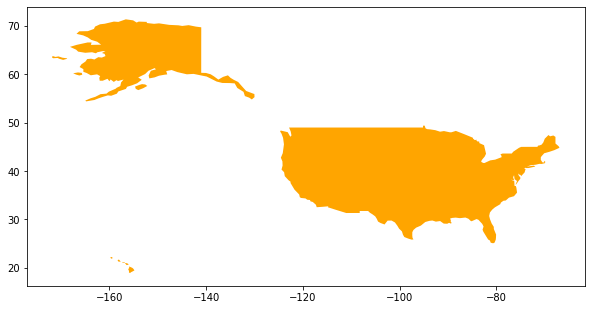

In [64]:
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world_map[world_map['name'] == 'United States of America']
fig,ax = plt.subplots(figsize=(10,8))
usa.plot(ax=ax, color='orange')

The next plot of the United States forms as a representation of which ports are the most popular and which ports are not for *people crossing*. This was represented with the aid of bubbles, wherein the larger the bubble, the greater the port's popularity has been from 1996-2019. It forms as a good gauge for predictive modelling, to identify what ports are the most popular (or the most active).

In [65]:
p_locs = total_people[['Location','Value']].groupby('Location').sum().reset_index()

# Getting the Longitude
def get_lon(point):
    par=point[7:-1].partition(' ')
    return float(par[0])

# Getting the Latitude
def get_lat(point):
    par=point[7:-1].partition(' ')
    return float(par[2])

# Utilising the port details to create the bubbles 
p_locs['lat']=p_locs.Location.apply(lambda x:get_lat(x))
p_locs['lon']=p_locs.Location.apply(lambda x:get_lon(x))

port_details = border_data[['Port Name', 'Location']].drop_duplicates().set_index('Location')
p_locs['Ports'] = p_locs.Location.apply(lambda x:','.join(port_details.loc[x].values.flatten()))
p_locs['text'] = p_locs['Ports']+'<br>Crossings:'+(p_locs['Value']/1e6).astype(str)+'million'

color="red"
scale=400000

# Utilising the map of the United States to separate it based on its states
fig=go.Figure()
fig.add_trace(go.Scattergeo(locationmode='USA-states',
                           lon=p_locs['lon'],
                           lat=p_locs['lat'],
                           text=p_locs['text'],
                           marker=dict(size=p_locs['Value']/scale, 
                                       color=color,
                                      line_color='rgb(40,40,40)',
                                      line_width=0.5,
                                      sizemode='area')))
# Final output figure
fig.update_layout(title_text='Inbound US Border Crossings of People (1996-2019)', 
                  showlegend=False,
                 geo=dict(scope='usa', landcolor='black'))
fig.show()

Similarly, the concentration of inbound vehicles into the United States was studied. Similar to the previous plot and analysis with the people, this one (done with respect to the vehicles), reveals the popularity based on the size of the bubbles. In other words, the bigger the bubble, the greater the port popularity is. Note that both these plots can be zoomed into the locations of interest, or zoomed out.

In [66]:
p_locs = total_vehicles[['Location','Value']].groupby('Location').sum().reset_index()

# Getting the Longitude
def get_lon(point):
    par=point[7:-1].partition(' ')
    return float(par[0])

# Getting the Latitude
def get_lat(point):
    par=point[7:-1].partition(' ')
    return float(par[2])

# Adding the Latitude and Longitude columns on our file
p_locs['lat']=p_locs.Location.apply(lambda x:get_lat(x))
p_locs['lon']=p_locs.Location.apply(lambda x:get_lon(x))

# Utilising the port details to create the bubbles 
port_details = border_data[['Port Name', 'Location']].drop_duplicates().set_index('Location')
p_locs['Ports'] = p_locs.Location.apply(lambda x:','.join(port_details.loc[x].values.flatten()))
p_locs['text'] = p_locs['Ports']+'<br>Crossings:'+(p_locs['Value']/1e6).astype(str)+'million'

color="red"
scale=400000

# Utilising the map of the United States to separate it based on its states
fig=go.Figure()
fig.add_trace(go.Scattergeo(locationmode='USA-states',
                           lon=p_locs['lon'],
                           lat=p_locs['lat'],
                           text=p_locs['text'],
                           marker=dict(size=p_locs['Value']/scale, 
                                       color=color,
                                      line_color='rgb(40,40,40)',
                                      line_width=0.5,
                                      sizemode='area')))

# Final output figure
fig.update_layout(title_text='Inbound US Border Crossings of Vehicles (1996-2019)', 
                  showlegend=False,
                 geo=dict(scope='usa', landcolor='black'))
fig.show()

In [100]:
border_predictions = pd.read_csv('Border_Crossing_Entry_Data.csv')

In [101]:
border_predictions['Date'] = pd.to_datetime(border_predictions['Date'])

In [102]:
border_predictions.head()

Port Name       State  Port Code            Border       Date  \
0  Calexico East  California       2507  US-Mexico Border 2019-03-01   
1      Van Buren       Maine        108  US-Canada Border 2019-03-01   
2      Otay Mesa  California       2506  US-Mexico Border 2019-03-01   
3        Nogales     Arizona       2604  US-Mexico Border 2019-03-01   
4    Trout River    New York        715  US-Canada Border 2019-03-01   

                       Measure  Value                               Location  
0                       Trucks  34447   POINT (-115.48433000000001 32.67524)  
1         Rail Containers Full    428             POINT (-67.94271 47.16207)  
2                       Trucks  81217            POINT (-117.05333 32.57333)  
3                       Trains     62  POINT (-110.93361 31.340279999999996)  
4  Personal Vehicle Passengers  16377   POINT (-73.44253 44.990010000000005)

In [103]:
border_crossing_predictions = border_predictions[['Date','Value']].groupby('Date').sum()
border_crossing_canada = border_predictions[border_predictions['Border'] == 'US-Canada Border'][['Date','Value']].groupby('Date').sum()
border_crossing_mexico = border_predictions[border_predictions['Border'] == 'US-Mexico Border'][['Date','Value']].groupby('Date').sum()

From 1996 to 2019

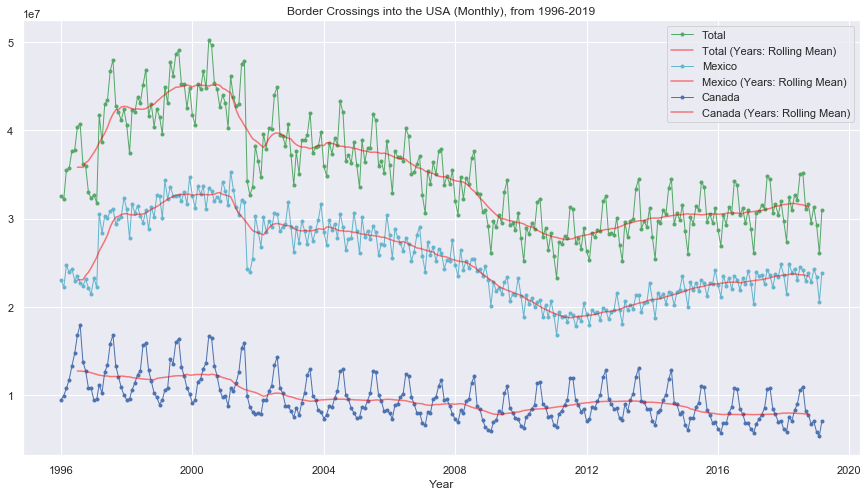

In [104]:
sns.set(rc = {'figure.figsize':(15,8)})
fig,ax = plt.subplots()

border_mean = border_crossing_predictions.rolling(12, center = True).mean()
border_mean_canada = border_crossing_canada.rolling(12, center = True).mean()
border_mean_mexico = border_crossing_mexico.rolling(12, center = True).mean()

ax.plot(border_crossing_predictions, marker = '.', linestyle = '-', linewidth = 1, alpha = 1, label = 'Total', color = 'g')
ax.plot(border_mean, marker = None, linestyle = '-', linewidth = 1.5, alpha = 0.5, label = 'Total (Years: Rolling Mean)', color = '#ff0000')

ax.plot(border_crossing_mexico, marker = '.', linestyle = '-', linewidth = 1, alpha = 1, label = 'Mexico', color = 'c')
ax.plot(border_mean_mexico, marker = None, linestyle = '-', linewidth = 1.5, alpha = 0.5, label = 'Mexico (Years: Rolling Mean)', color = '#ff0000')

ax.plot(border_crossing_canada, marker = '.', linestyle = '-', linewidth = 1, alpha = 1, label = 'Canada', color = 'b')
ax.plot(border_mean_canada, marker = None, linestyle = '-', linewidth = 1.5, alpha = 0.5, label = 'Canada (Years: Rolling Mean)', color = '#ff0000')

ax.set(title = 'Border Crossings into the USA (Monthly), from 1996-2019', xlabel = 'Year')
ax.legend()

plt.show()

From 2010 - 2019

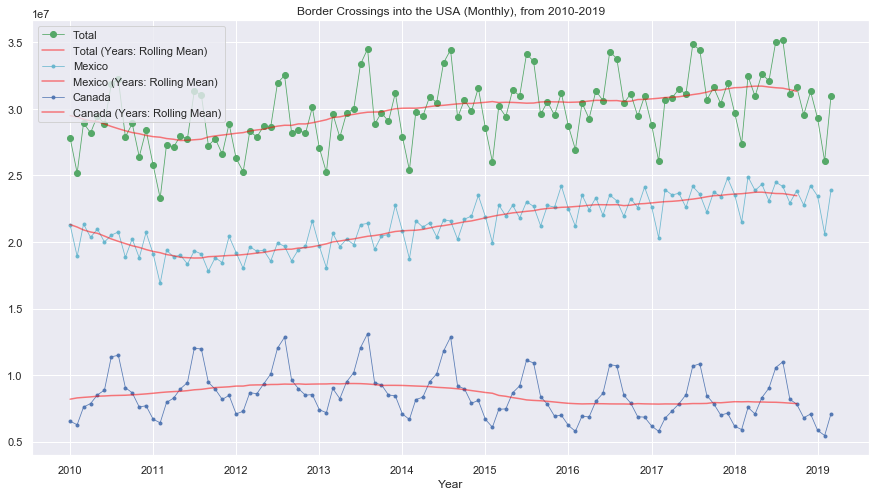

In [105]:
fig,ax = plt.subplots()
start = '2010'
end = '2019'

ax.plot(border_crossing_predictions.loc[start:end], marker = 'o', linestyle = '-', linewidth = 0.8, alpha = 1, label = 'Total', color = 'g')
ax.plot(border_mean.loc[start:end], marker = None, linestyle = '-', linewidth = 1.5, alpha = 0.5, label = 'Total (Years: Rolling Mean)', color = '#ff0000')

ax.plot(border_crossing_mexico.loc[start:end], marker = '.', linestyle = '-', linewidth = 0.8, alpha = 0.9, label = 'Mexico', color = 'c')
ax.plot(border_mean_mexico[start:end], marker = None, linestyle = '-', linewidth = 1.5, alpha = 0.5, label = 'Mexico (Years: Rolling Mean)', color = '#ff0000')

ax.plot(border_crossing_canada.loc[start:end], marker = '.', linestyle = '-', linewidth = 0.8, alpha = 0.9, label = 'Canada', color = 'b')
ax.plot(border_mean_canada.loc[start:end], marker = None, linestyle = '-', linewidth = 1.5, alpha = 0.5, label = 'Canada (Years: Rolling Mean)', color = '#ff0000')

ax.set(title = 'Border Crossings into the USA (Monthly), from 2010-2019', xlabel = 'Year')
ax.legend()

plt.show()

From 2015 to 2019

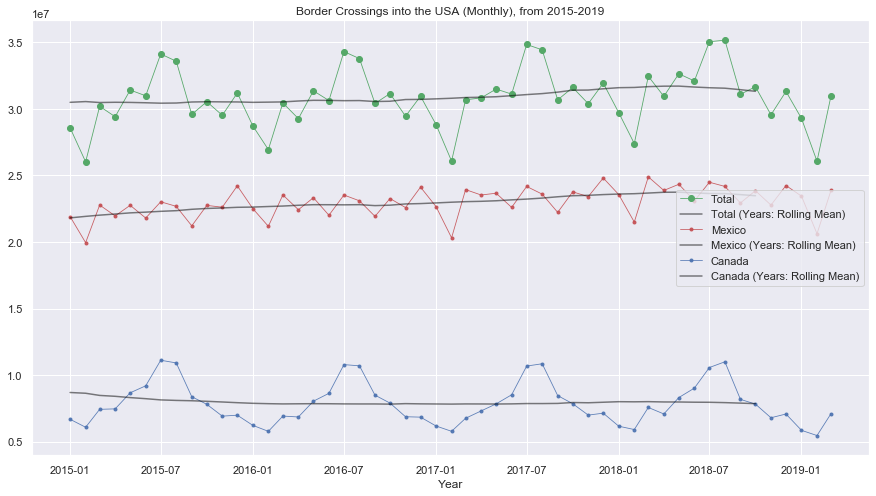

In [106]:
fig,ax = plt.subplots()
start = '2015'
end = '2019'

ax.plot(border_crossing_predictions.loc[start:end], marker = 'o', linestyle = '-', linewidth = 0.8, alpha = 1, label = 'Total', color = 'g')
ax.plot(border_mean.loc[start:end], marker = None, linestyle = '-', linewidth = 1.5, alpha = 0.5, label = 'Total (Years: Rolling Mean)', color = 'black')

ax.plot(border_crossing_mexico.loc[start:end], marker = '.', linestyle = '-', linewidth = 0.8, alpha = 0.9, label = 'Mexico', color = 'r')
ax.plot(border_mean_mexico[start:end], marker = None, linestyle = '-', linewidth = 1.5, alpha = 0.5, label = 'Mexico (Years: Rolling Mean)', color = 'black')

ax.plot(border_crossing_canada.loc[start:end], marker = '.', linestyle = '-', linewidth = 0.8, alpha = 0.9, label = 'Canada', color = 'b')
ax.plot(border_mean_canada.loc[start:end], marker = None, linestyle = '-', linewidth = 1.5, alpha = 0.5, label = 'Canada (Years: Rolling Mean)', color = 'black')

ax.set(title = 'Border Crossings into the USA (Monthly), from 2015-2019', xlabel = 'Year')
ax.legend()

plt.show()

The above years were broken down to see if there were any intersections in the years of inbound travellers to the United States. Since there was an intersection between the crossing data in the first graph (between 1996-2009, occurring around 2001), we want to see a more undisturbed timephase. This was first noticeable in the second graph from 2010-2019, where no intersections were visible. 

From this study, we use this knowledge to now transform the data to see if there is a seasonal trend, which means the frequency and the wavelengths should not decrease and cause an intersection to occur. This tells us whether the data is stationary or not. This way, conducting the ARIMA will make sense, as this will enable in decomposing the data and transform it.

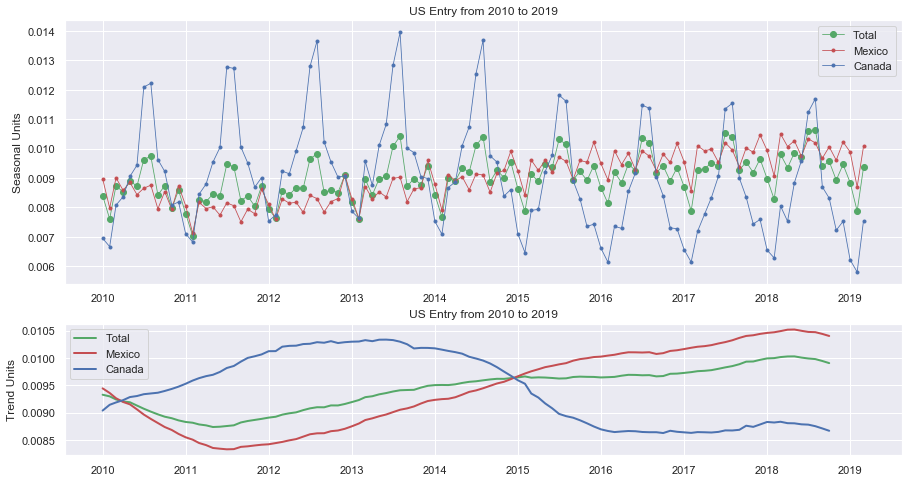

In [151]:
fig = plt.figure()

grid = mgrid.GridSpec(nrows=2, ncols=1, height_ratios=[2,1])

seas = fig.add_subplot(grid[0])
trend = fig.add_subplot(grid[1], sharex=seas)

start = '2010'
end = '2019'

seas.plot(border_crossing_predictions.loc[start:end]/border_crossing_predictions.loc[start:end].sum(), 
          marker = 'o',
         linestyle = '-',
         linewidth = 0.8,
         alpha = 1,
         label = 'Total',
         color = 'g')

seas.plot(border_crossing_mexico.loc[start:end]/border_crossing_mexico.loc[start:end].sum(), 
          marker = '.',
         linestyle = '-',
         linewidth = 0.8,
         alpha = 1.0,
         label = 'Mexico',
         color = 'r')

seas.plot(border_crossing_canada.loc[start:end]/border_crossing_canada.loc[start:end].sum(), 
          marker = '.',
         linestyle = '-',
         linewidth = 0.8,
         alpha = 1.0,
         label = 'Canada',
         color = 'b')

seas.set(title = 'US Entry from 2010 to 2019'.format(start, end), ylabel = 'Seasonal Units')
seas.legend()

trend.plot(border_mean.loc[start:end]/border_mean.loc[start:end].sum(),
           marker = ' ',
         linestyle = '-',
         linewidth = 2,
         alpha = 1,
         label = 'Total',
         color = 'g')

trend.plot(border_mean_mexico.loc[start:end]/border_mean_mexico.loc[start:end].sum(),
           marker = ' ',
         linestyle = '-',
         linewidth = 2,
         alpha = 1,
         label = 'Mexico',
         color = 'r')

trend.plot(border_mean_canada.loc[start:end]/border_mean_canada.loc[start:end].sum(),
           marker = ' ',
         linestyle = '-',
         linewidth = 2,
         alpha = 1,
         label = 'Canada',
         color = 'b')

trend.set(title = 'US Entry from 2010 to 2019'.format(start, end), ylabel = 'Trend Units')
trend.legend()

### Decomposition of the data

Seasonal decomposition

In [158]:
s_decomp = border_crossing_predictions.loc['2010':]

Additive and multiplicative decomposition

In [159]:
add_decomp = seasonal_decompose(s_decomp, model = 'additive', extrapolate_trend = 'freq')
mult_decomp = seasonal_decompose(s_decomp, model = 'multiplicative', extrapolate_trend = 'freq')

Text(0, 0.5, 'Residual')

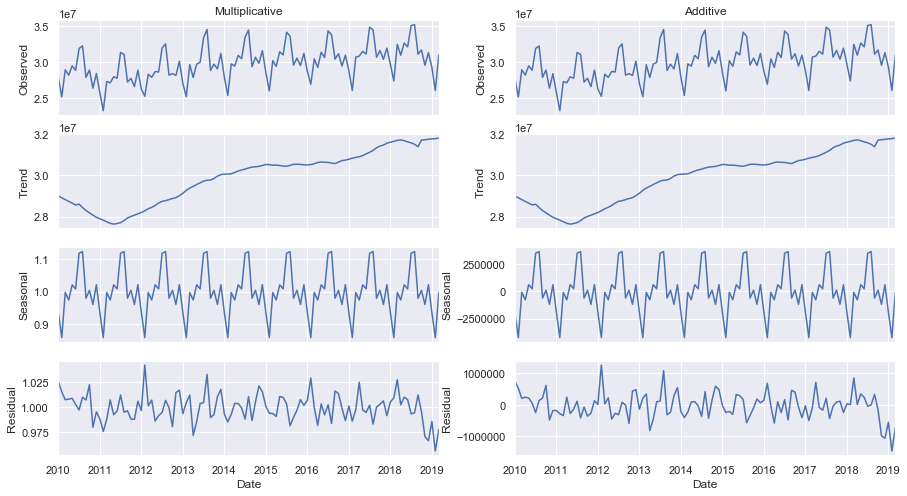

In [110]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True)

# The column orders of the graphs
axes[0,0].set_title('Multiplicative')
axes[0,1].set_title('Additive')

# Multiplicative Decomposition - Observed, Trend, Seasonal & Residual (in the respective order)
mult_decomp.observed.plot(ax=axes[0,0], legend = False)
axes[0,0].set_ylabel('Observed')
mult_decomp.trend.plot(ax=axes[1,0], legend = False)
axes[1,0].set_ylabel('Trend')
mult_decomp.seasonal.plot(ax=axes[2,0], legend = False)
axes[2,0].set_ylabel('Seasonal')
mult_decomp.resid.plot(ax=axes[3,0], legend = False)
axes[3,0].set_ylabel('Residual')

# Additive Decomposition - Observed, Trend, Seasonal & Residual (in the respective order)
add_decomp.observed.plot(ax=axes[0,1], legend = False)
axes[0,1].set_ylabel('Observed')
add_decomp.trend.plot(ax=axes[1,1], legend = False)
axes[1,1].set_ylabel('Trend')
add_decomp.seasonal.plot(ax=axes[2,1], legend = False)
axes[2,1].set_ylabel('Seasonal')
add_decomp.resid.plot(ax=axes[3,1], legend = False)
axes[3,1].set_ylabel('Residual')

The above graphs are both additively and multiplicatively the same. So in order to proceed, we shall stick with the multiplicative data. Often when trying to conduct an ARIMA, you want to choose the data that has been transformed the greatest (which in this case is the multiplicative data). This way you can be certain that if there is no difference, you have conducted enough analyses and still have insufficient evidence to deduce that the transformed data is not following a stationary process (thus far).

### Forecasting using ARIMA

Here we want to employ linear regression in order to prove that the transformed data does follow a stationary process. If after this, there is still no evidence then we have insufficient evidence to reject the null hypothesis. So firstly, we need to remove the seasonal component to conduct the ARIMA.

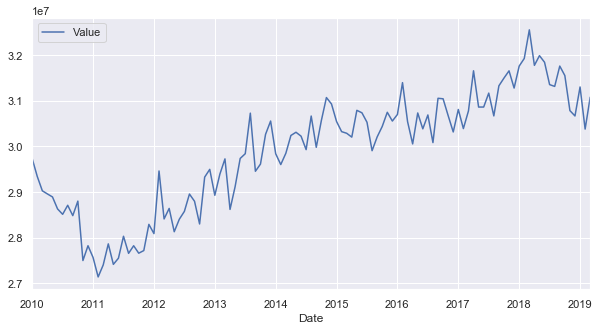

In [161]:
# The removal of the seasonal component
deseason_data = mult_decomp.resid * mult_decomp.trend
deseason_data.plot(figsize = (10,5))

In [163]:
border_crossing_predictions.tail(1)

Value
Date                
2019-03-01  30987561

Also to quickly make sure, we want to see if the p-value is significant, in order to deduce that the transformed data follows stationary process. If P-Value is greater than 5%, then it is *not stationary*.

In [164]:
res = adfuller(deseason_data.Value.dropna())
print('ADF Statistic is %f' % res[0])
print('P-Value is %f' % res[1])

ADF Statistic is -0.858136
P-Value is 0.801446


This is **not stationary**.

### Working out the Auto-Correlation Function (ACF) in order to forecast

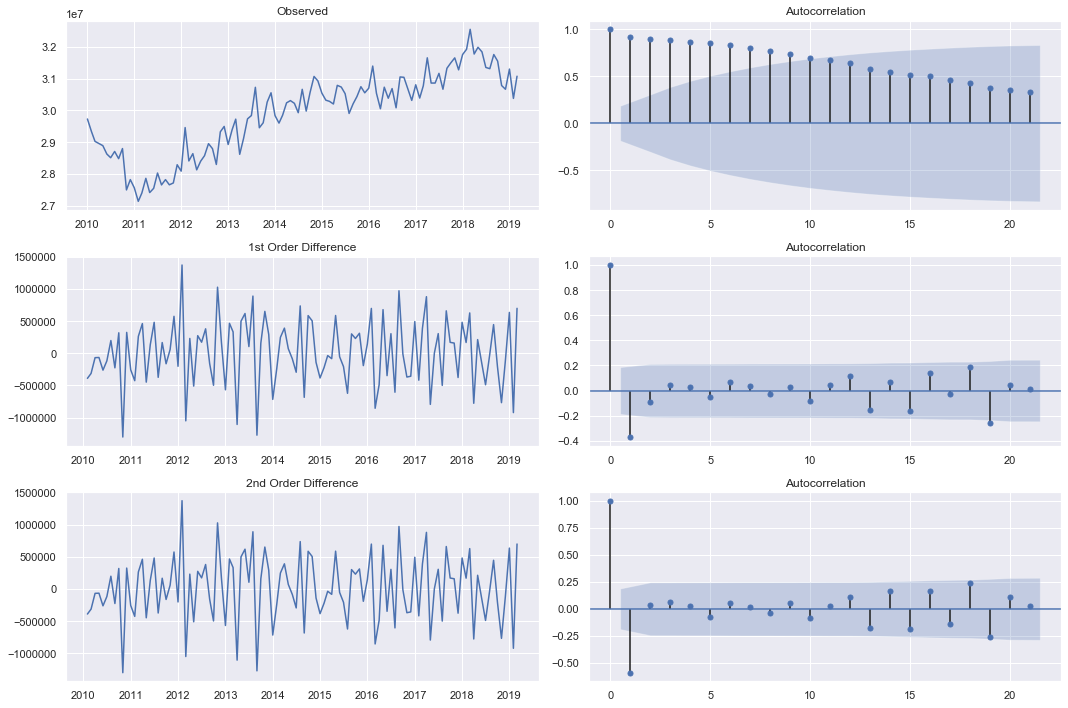

In [165]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))

# Observed 
axes[0,0].plot(deseason_data.Value)
axes[0,0].set_title('Observed')
plot_acf(deseason_data, ax=axes[0,1])

# 1st Order Difference
axes[1,0].plot(deseason_data.Value.diff()), axes[1,0].set_title('1st Order Difference')
plot_acf(deseason_data.diff().dropna(), ax=axes[1,1])

# 2nd Order Difference
axes[2,0].plot(deseason_data.Value.diff()); axes[2,0].set_title('2nd Order Difference')
plot_acf(deseason_data.diff().diff().dropna(), ax=axes[2,1])

plt.tight_layout()
plt.show()

In [166]:
res = adfuller(deseason_data.diff().Value.dropna())
print('ADF Statistic is %f' % res[0])
print('P-Value is %f' % res[1])

ADF Statistic is -8.643346
P-Value is 0.000000


Foreword: Upon checking the P-Value, we can see that the value is significant, meaning that we have a stationary series that we need to observe and analyse.

*Observed:* The observed data is following an increasing trend, and this means that the observed data **does not follow** a stationary process.

*1st Order:* The 1st Order Difference appears to have a constant mean, and more so, we can see that the autocorrelations have been contained. This means the 1st Order Difference **follows** a stationary process.

*2nd Order:* The 2nd Order Difference is a repeat of the 1st Order's pattern, which means it has been over-differentiated. That means the 2nd Order Difference **does not follow** a stationary process.

### Working out the Partial Auto-Correlation Function (PACF) in order to forecast

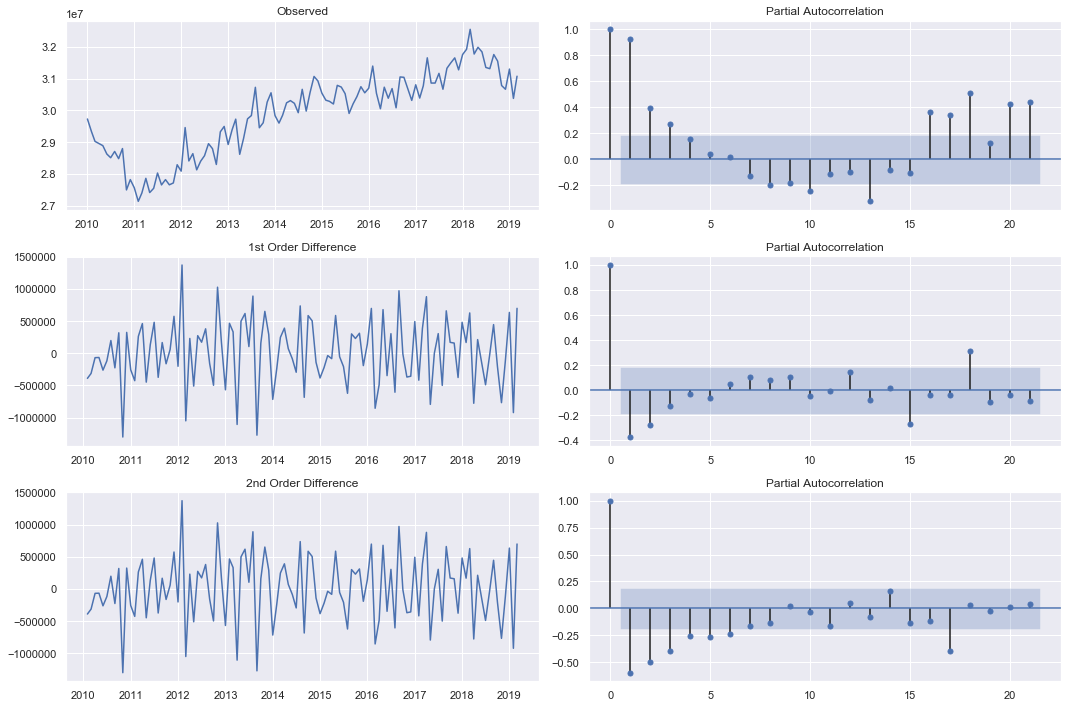

In [167]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))

# Observed 
axes[0,0].plot(deseason_data.Value)
axes[0,0].set_title('Observed')
plot_pacf(deseason_data, ax=axes[0,1])

# 1st Order Difference
axes[1,0].plot(deseason_data.Value.diff()), axes[1,0].set_title('1st Order Difference')
plot_pacf(deseason_data.diff().dropna(), ax=axes[1,1])

# 2nd Order Difference
axes[2,0].plot(deseason_data.Value.diff()); axes[2,0].set_title('2nd Order Difference')
plot_pacf(deseason_data.diff().diff().dropna(), ax=axes[2,1])

plt.tight_layout()
plt.show()

Overall, we can stick with a *1st Order Difference of Data*, and this means that the:
- **Auto-Regression (from the PACF):** Has 1 autocorrelation. So *p=1*.
- **Integrated (with the model we're choosing):** Has a non-seasonal difference of 1. So *d=1*.
- **Moving Average (from the ACF):** Has 1 partial autocorrelation. So *q=1*.

This means our ARIMA model is (p,d,q) = (1,1,1), based on the above.

In [168]:
model = ARIMA(deseason_data, order=(1,1,1))
model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  110
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1589.221
Method:                       css-mle   S.D. of innovations         454534.434
Date:                Sun, 22 Dec 2019   AIC                           3186.443
Time:                        18:02:46   BIC                           3197.244
Sample:                    02-01-2010   HQIC                          3190.824
                         - 03-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.225e+04   2.03e+04      0.603      0.548   -2.75e+04     5.2e+04
ar.L1.D.Value     0.0373      0.155      0.241      0.810      -0.266       0.341
ma.L1.D.Value    -0.5562      0.121     

/Users/arjun/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/arjun/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Seeing that the AR(1) value is not significant, we need to make it AR(0), and MA(1) and remove the difference, so that ARIMA model becomes (p,d,q) = (1,0,1).

In [169]:
model = ARIMA(deseason_data, order=(0,0,1))
model_fit = model.fit(disp=0)

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  111
Model:                     ARMA(0, 1)   Log Likelihood               -1675.225
Method:                       css-mle   S.D. of innovations         864568.824
Date:                Sun, 22 Dec 2019   AIC                           3356.450
Time:                        18:02:50   BIC                           3364.579
Sample:                    01-01-2010   HQIC                          3359.748
                         - 03-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.989e+07    1.4e+05    213.492      0.000    2.96e+07    3.02e+07
ma.L1.Value     0.7126      0.049     14.632      0.000       0.617       0.808
                                    Roots       

/Users/arjun/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



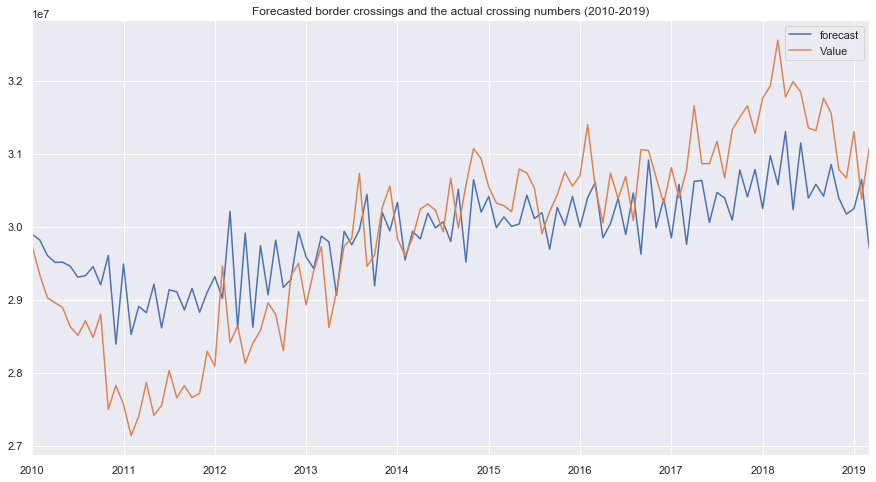

In [170]:
model_fit.plot_predict()
plt.title('Forecasted border crossings and the actual crossing numbers (2010-2019)')
plt.show()

In [171]:
print(len(deseason_data))
print(len(deseason_data)*0.75)

111
83.25


/Users/arjun/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/arjun/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



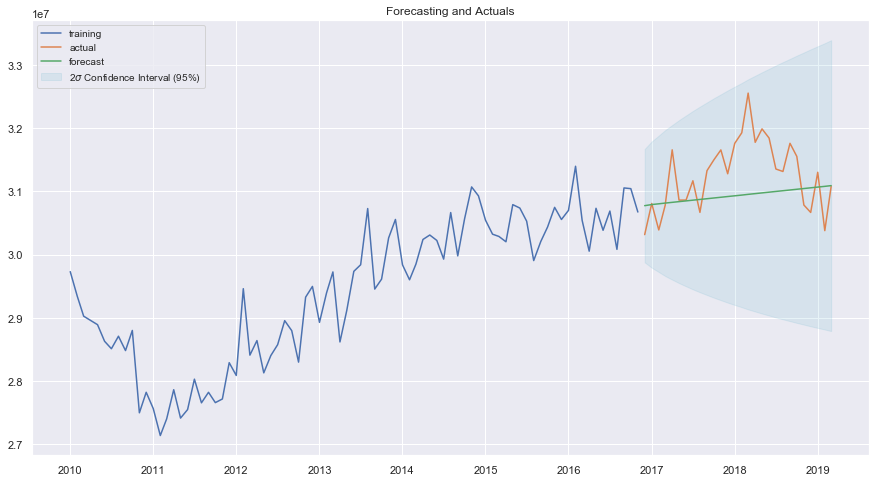

In [185]:
train = deseason_data[:83]
test = deseason_data[83:]

model_train = ARIMA(train, order=(1,1,1))
fitted_train = model_train.fit(disp=-1)

fc, se, conf = fitted_train.forecast(28, alpha=0.05)

fc_series = pd.Series(fc, index=test.index)
low_series = pd.Series(conf[:, 0], index=test.index)
upp_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(15,8))
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(fc_series, label='forecast')

# Confidence Intervals
plt.fill_between(low_series.index, low_series, upp_series, color = 'c', alpha = 0.15, label = '2$\sigma$ Confidence Interval (95%)')
plt.title('Forecasting and Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [173]:
border_crossing_predictions.tail(1)

Value
Date                
2019-03-01  30987561

/Users/arjun/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/arjun/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



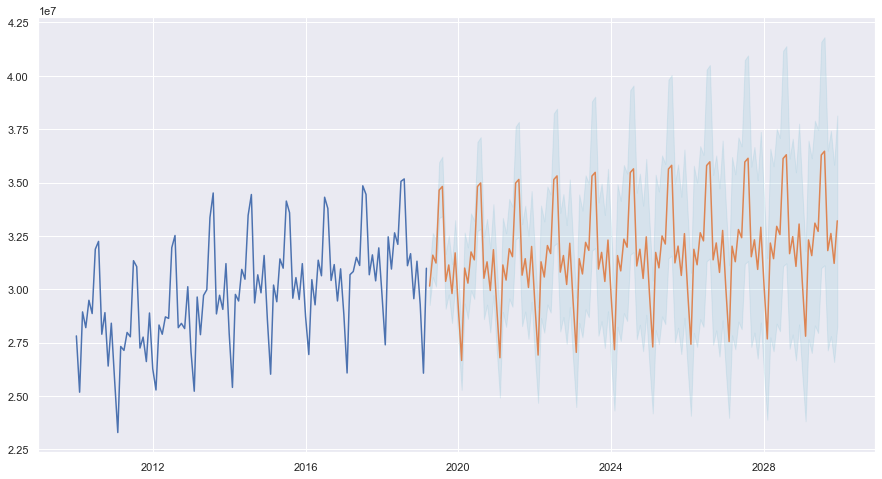

In [211]:
start_date = border_crossing_predictions.tail(1).index[0]
end_date = '2029-12-01'
date_info = pd.date_range(start=start_date, end=end_date, freq='MS', closed = 'right')
forecast_info = len(date_info) # number of steps to forecast

seasonal = mult_decomp.seasonal.loc['2018-01-01':'2018-12-01'].values 
series_info = pd.Series(np.tile(seasonal.flatten(), 11), index = pd.date_range(start='2019-01-01', end = '2029-12-01', freq='MS'))  

def make_seasonal(ser) :
    seasonal_series = ser * series_info # Include the seasonality
    seasonal_series = seasonal_series[~seasonal_series.isnull()] # trim extra values
    return seasonal_series
    
# Forecast

model = ARIMA(deseason_data, order=(1,1,1))
model_fit = model.fit(disp=0)

fc1, se1, conf1 = model_fit.forecast(forecast_info, alpha = 0.0455)  
fc2, se2, conf2 = model_fit.forecast(forecast_info, alpha = 0.3173)

# Pandas 
fc1_series = pd.Series(fc1, index = date_info)
lower_series1 = pd.Series(conf1[:, 0], index = date_info)
upper_series1 = pd.Series(conf1[:, 1], index = date_info)

# Seasonality
fc1_series, lower_series1, upper_series1 = [make_seasonal(fc1_series), make_seasonal(lower_series1), make_seasonal(upper_series1)]

# Plot info
plt.plot(deseason_data * mult_decomp.seasonal, label='data')
plt.plot(fc1_series, label='forecast')
plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='c', alpha=0.15, label='2$\sigma$ Confidence Interval at 95%')

In [218]:
border_crossing_predictions.tail(50)/1000000

Value
Date                 
2015-02-01  26.024213
2015-03-01  30.199052
2015-04-01  29.417774
2015-05-01  31.423788
2015-06-01  30.989684
2015-07-01  34.134300
2015-08-01  33.588396
2015-09-01  29.584352
2015-10-01  30.549665
2015-11-01  29.525381
2015-12-01  31.203099
2016-01-01  28.725205
2016-02-01  26.945918
2016-03-01  30.452835
2016-04-01  29.272861
2016-05-01  31.364781
2016-06-01  30.635189
2016-07-01  34.313546
2016-08-01  33.787557
2016-09-01  30.414466
2016-10-01  31.158564
2016-11-01  29.454332
2016-12-01  30.958929
2017-01-01  28.826910
2017-02-01  26.081678
2017-03-01  30.687520
2017-04-01  30.833570
2017-05-01  31.496810
2017-06-01  31.116972
2017-07-01  34.848911
2017-08-01  34.444384
2017-09-01  30.681937
2017-10-01  31.614001
2017-11-01  30.397246
2017-12-01  31.941337
2018-01-01  29.716207
2018-02-01  27.400251
2018-03-01  32.458891
2018-04-01  30.949588
2018-05-01  32.646367
2018-06-01  32.105809
2018-07-01  35.056685
2018-08-01  35.170600
2018-09-01  31.105680
2018-10-01  31.669698
2018-11-01  29.560756
2018-12-01  31.316998
2019-01-01  29.288519
2019-02-01  26.072319
2019-03-01  30.987561

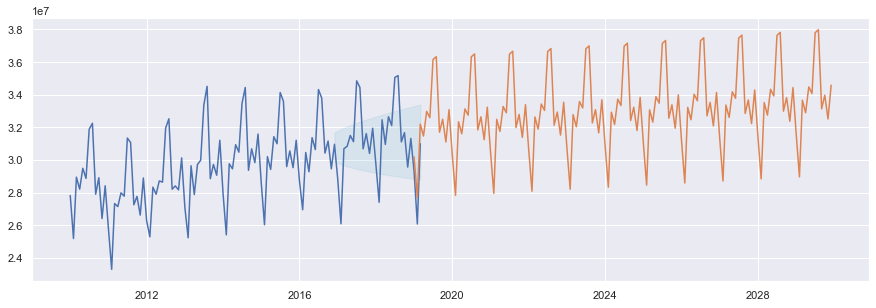

In [202]:
fig = plt.figure()

grid = mgrid.GridSpec(nrows=2, ncols=1, height_ratios=[2,1])
sns.set(rc={'figure.figsize':(15,8)})

seas = fig.add_subplot(grid[0], sharex=seas)

seas.plot(deseason_data * mult_decomp.seasonal, label='data')
seas.plot(fc1_series, label='forecast')
seas.fill_between(low_series.index, low_series, upp_series, color='c', alpha=0.15, label='2$\sigma$ Confidence Interval at 95%')
